In [ ]:
import requests
import json
import pandas as pd
import datetime
# time_start is 1 January 2022
time_start = datetime.datetime(2022, 1, 1)
time_end = datetime.datetime.now()

# Konversi waktu ke format timestamp Unix
time_end_unix = int(time_end.timestamp())
time_start_unix = int(time_start.timestamp())

# Define the API URL
api_url = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id=1&convertId=2794&timeStart={time_start_unix}&timeEnd={time_end_unix}'

print(api_url)

r = requests.get(api_url)
data = []

# Extract data from the API response
for item in r.json()['data']['quotes']:
    close = item['quote']['close']
    volume = item['quote']['volume']
    date = item['quote']['timestamp']
    high = item['quote']['high']
    low = item['quote']['low']
    open = item['quote']['open']
    data.append([close, volume, date, high, low, open])

# Define column names for the DataFrame
cols = ["close", "volume", "date", "high", "low", "open"]

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=cols)

# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['date'])

# Save the DataFrame to a CSV file
csv_filename = 'crypto_data.csv'
df.to_csv(csv_filename, index=False)

print(f'Data saved to {csv_filename}')

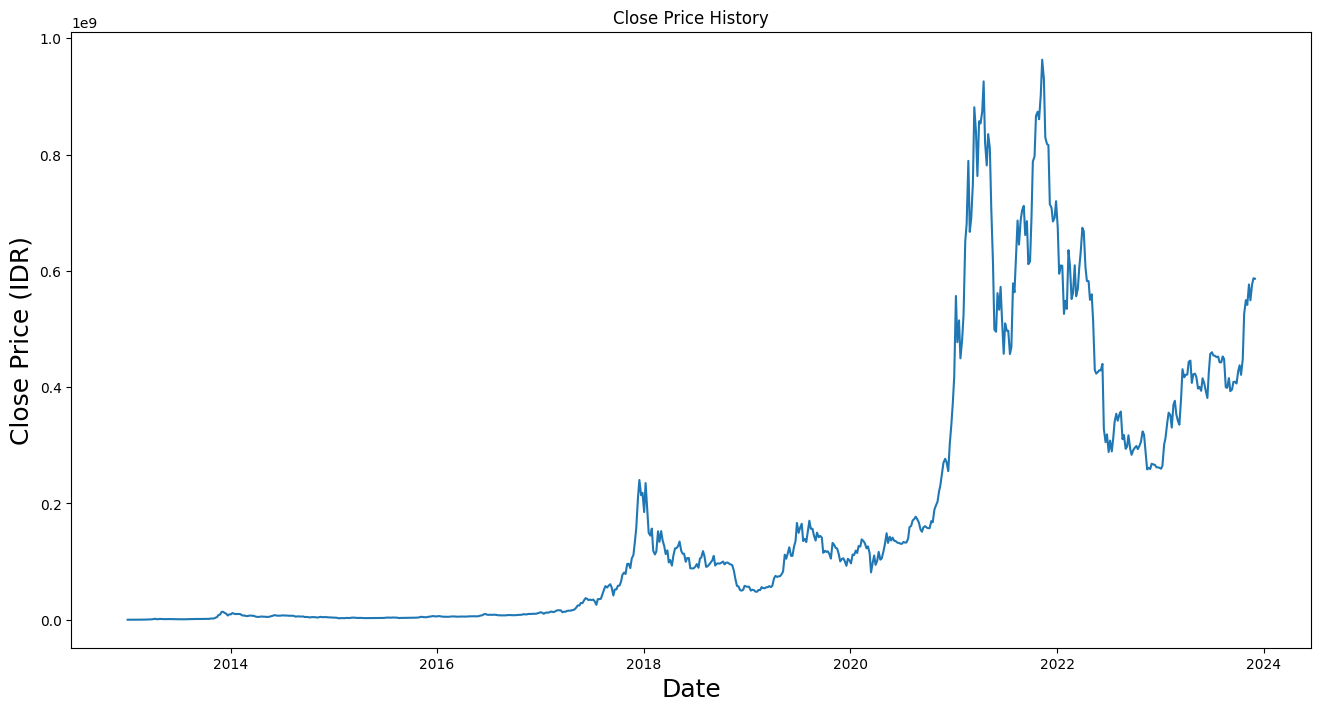

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from pyswarm import pso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from math import sqrt
from joblib import Parallel, delayed

# Load the data
df = pd.read_csv('crypto_data.csv')

# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by date
df.sort_values(by='date', inplace=True, ascending=True)

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Close Price History')
plt.plot(df['date'], df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (IDR)', fontsize=18)
plt.show()

# save image
plt.savefig('close_price_history.png')

In [ ]:
# Preprocess the data
df = df[['close', 'volume', 'high', 'low', 'open']]

# Split the data into train and test
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Scale the data
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# Split the data into X_train, y_train, X_test, y_test
X_train = train[:, 1:]
y_train = train[:, 0]
X_test = test[:, 1:]
y_test = test[:, 0]

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:

# Define hyperparameter search space
bounds = [(50, 150), (0.1, 0.5), (0.0001, 0.1), (25, 100), (16, 256)] # Number of units, dropout rate, learning rate, epochs, batch size

# Define the cost function for PSO
def cost_func(x, X_train, y_train, X_test, y_test):
    # Convert particle position to hyperparameters
    num_units = int(x[0])
    dropout_rate = x[1]
    learning_rate = x[2]
    print(f'num_units: {num_units}, dropout_rate: {dropout_rate}, learning_rate: {learning_rate}, epochs: {int(x[3])}, batch_size: {int(x[4])}')
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

    # Train the model
    model.fit(X_train, y_train, epochs=int(x[3]), batch_size=int(x[4]),
              validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], verbose=0)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
# Run PSO
best_params, _ = pso(cost_func, lb=np.array(bounds)[:, 0], ub=np.array(bounds)[:, 1], swarmsize=20, maxiter=20,
                     args=(X_train, y_train, X_test, y_test))

# Display results
print('Best Hyperparameters:', best_params)

In [ ]:

# Create LSTM model
num_units = int(best_params[0]) + 1
dropout_rate = best_params[1]
learning_rate = best_params[2]
epochs = int(best_params[3]) + 1
batch_size = int(best_params[4]) + 1
# Create LSTM model using best hyperparameters
model = Sequential()
model.add(LSTM(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model using the best hyperparameters
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Make predictions on the test set
y_pred = model.predict(X_test)

# Save the model
model.save('model.h5')

# Summary of the model
print(model.summary())

# Plot the model
tf.keras.utils.plot_model(model, to_file='complex_model.png', show_shapes=True, show_layer_names=True)

# Show the model architecture
from IPython.display import Image
Image(retina=True, filename='complex_model.png')

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# Visualize the actual vs. predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD (IDR)', fontsize=18)
plt.legend()
plt.show()

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# load model
model = tf.keras.models.load_model('model.h5')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert regression predictions to binary labels (1 if y_pred > threshold else 0)
threshold = 0.5  # Adjust the threshold as needed
y_pred_binary = (y_pred > threshold).astype(int)

# Convert actual values to binary labels
y_test_binary = (y_test > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# Print the results
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display classification report
print('\nClassification Report:')
print(classification_report(y_test_binary, y_pred_binary))
